In [1]:
import pandas as pd
import glob
import os
import numpy as np

In [14]:
def read_atp_matches():
    """
    Read all ATP match files from 1968 to 2024 and combine them into a single DataFrame.
    Returns:
        pd.DataFrame: Combined DataFrame containing all ATP matches
    """
    # Get the directory path where the ATP match files are located
    data_dir = 'tennis_atp-master'
    
    # Create a pattern to match all ATP match files from 1968 to 2024
    pattern = os.path.join(data_dir, 'atp_matches_[0-9][0-9][0-9][0-9].csv')
    
    # Get all matching files
    match_files = glob.glob(pattern)
    
    # Read and combine all files
    dfs = []
    for file in sorted(match_files):
        try:
            df = pd.read_csv(file)
            # Add a year column based on the filename
            year = int(os.path.basename(file).split('_')[2].split('.')[0])
            df['year'] = year
            dfs.append(df)
            print(f"Successfully read {file}")
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
    
    # Combine all DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"\nTotal number of matches: {len(combined_df)}")
        print(f"Date range: {combined_df['year'].min()} to {combined_df['year'].max()}")
        return combined_df
    else:
        print("No files were successfully read")
        return None

In [15]:
matches = read_atp_matches()

Successfully read tennis_atp-master/atp_matches_1968.csv
Successfully read tennis_atp-master/atp_matches_1969.csv
Successfully read tennis_atp-master/atp_matches_1970.csv
Successfully read tennis_atp-master/atp_matches_1971.csv
Successfully read tennis_atp-master/atp_matches_1972.csv
Successfully read tennis_atp-master/atp_matches_1973.csv
Successfully read tennis_atp-master/atp_matches_1974.csv
Successfully read tennis_atp-master/atp_matches_1975.csv
Successfully read tennis_atp-master/atp_matches_1976.csv
Successfully read tennis_atp-master/atp_matches_1977.csv
Successfully read tennis_atp-master/atp_matches_1978.csv
Successfully read tennis_atp-master/atp_matches_1979.csv
Successfully read tennis_atp-master/atp_matches_1980.csv
Successfully read tennis_atp-master/atp_matches_1981.csv
Successfully read tennis_atp-master/atp_matches_1982.csv
Successfully read tennis_atp-master/atp_matches_1983.csv
Successfully read tennis_atp-master/atp_matches_1984.csv
Successfully read tennis_atp-ma

In [4]:
matches.to_csv('matches.csv', index=False)

In [4]:
matches = matches[matches['year'] < 2020]

In [5]:
# Expand to one row per player per match
match_rows = []

for i, row in matches.iterrows():
    for role in ['winner', 'loser']:
        # Compute return stats
        opp_prefix = 'l' if role == 'winner' else 'w'
        opp_1st_in = row[f'{opp_prefix}_1stIn']
        opp_1st_won = row[f'{opp_prefix}_1stWon']
        opp_2nd_won = row[f'{opp_prefix}_2ndWon']
        opp_svpt = row[f'{opp_prefix}_svpt']

        return_1st_won = opp_1st_in - opp_1st_won if pd.notna(opp_1st_in) and pd.notna(opp_1st_won) else np.nan
        return_1st_total = opp_1st_in
        return_2nd_won = opp_svpt - opp_1st_in - opp_2nd_won if pd.notna(opp_svpt) and pd.notna(opp_1st_in) and pd.notna(opp_2nd_won) else np.nan
        return_2nd_total = opp_svpt - opp_1st_in if pd.notna(opp_svpt) and pd.notna(opp_1st_in) else np.nan
        return_total_won = return_1st_won + return_2nd_won

        player_stats = {
            'year': row['year'],
            'tourney_id': row['tourney_id'],
            'tourney_name': row['tourney_name'],
            'tourney_date': row['tourney_date'],
            'tourney_level': row['tourney_level'],
            'player_id': row[f'{role}_id'],
            'player_name': row[f'{role}_name'],
            'player_seed': row[f'{role}_seed'],
            'player_rank': row[f'{role}_rank'],
            'player_points': row[f'{role}_rank_points'],
            'player_hand': row[f'{role}_hand'],
            'player_ht': row[f'{role}_ht'],
            'player_ioc': row[f'{role}_ioc'],
            'player_age': row[f'{role}_age'],
            'surface': row['surface'],
            'is_winner': 1 if role == 'winner' else 0,
            'score': row['score'],
            'round': row['round'],
            'minutes': row['minutes'],
            'best_of': row['best_of'],
            'year': row['year'],
            'aces': row[f'{role[0]}_ace'],
            'double_faults': row[f'{role[0]}_df'],
            '1st_in': row[f'{role[0]}_1stIn'],
            '1st_won': row[f'{role[0]}_1stWon'],
            '2nd_won': row[f'{role[0]}_2ndWon'],
            'bp_saved': row[f'{role[0]}_bpSaved'],
            'bp_faced': row[f'{role[0]}_bpFaced'],
            'svpt': row[f'{role[0]}_svpt'],

            # Return stats
            'return_1st_won': return_1st_won,
            'return_1st_total': return_1st_total,
            'return_2nd_won': return_2nd_won,
            'return_2nd_total': return_2nd_total,
            'return_total_won': return_total_won,
            'return_total_pts': opp_svpt
        }
        match_rows.append(player_stats)


player_df = pd.DataFrame(match_rows)



In [6]:
player_df.to_csv('expanded_matches.csv', index=False)

In [151]:
print("Num of rows with NA for svpt:", len(player_df[player_df['svpt'].isna()]))


Num of rows with NA for svpt: 192798


In [19]:
og_player_df = player_df.copy()

In [20]:

# Calculate serve and return stats
print("Num of rows with NA for svpt:", len(og_player_df[og_player_df['svpt'].isna()]))
player_df = og_player_df[og_player_df['svpt'].notna()].copy()

player_df['ace_rate'] = player_df['aces'] / player_df['svpt']
player_df['df_rate'] = player_df['double_faults'] / player_df['svpt'] 
player_df['1st_serve_in_pct'] = player_df['1st_in'] / player_df['svpt']
player_df['1st_serve_win_pct'] = player_df['1st_won'] / player_df['1st_in']
player_df['2nd_serve_win_pct'] = player_df['2nd_won'] / (player_df['svpt'] - player_df['1st_in'] - player_df['double_faults'])
player_df['2nd_serve_in_pct'] = (player_df['svpt'] - player_df['1st_in'] - player_df['double_faults']) / (player_df['svpt'] - player_df['1st_in'])
player_df.loc[player_df['bp_saved'] < 0, 'bp_saved'] = 0
player_df['bp_saved_pct'] = player_df['bp_saved'] / player_df['bp_faced']

# Print rows with NA values for 1st_serve_in_pct
print("\nRows with NA for 1st_serve_in_pct:")
print(player_df[player_df['svpt'].isna()][['player_id', 'player_name', 'year', '1st_in', 'svpt']])

# Calculate return stats
player_df['return_1st_win_pct'] = player_df['return_1st_won'] / player_df['return_1st_total']
player_df['return_2nd_win_pct'] = player_df['return_2nd_won'] / player_df['return_2nd_total']
player_df['return_total_win_pct'] = player_df['return_total_won'] / player_df['return_total_pts']


# Step 1: Group by player_id and compute means
player_means = player_df.groupby('player_id').agg({
    'player_name': 'first',
    '1st_serve_win_pct': lambda x: x.dropna().mean(),
    '1st_serve_in_pct': lambda x: x.dropna().mean(),
    '2nd_serve_win_pct': lambda x: x.dropna().mean(),
    '2nd_serve_in_pct': lambda x: x.dropna().mean(),
    'ace_rate': lambda x: x.dropna().mean(),
    'df_rate': lambda x: x.dropna().mean(),
    'bp_saved_pct': lambda x: x.dropna().mean(),
    'return_1st_win_pct': lambda x: x.dropna().mean(),
    'return_2nd_win_pct': lambda x: x.dropna().mean(),
    'return_total_win_pct': lambda x: x.dropna().mean()
}).reset_index()

# Rename columns to include '_mean'
player_means = player_means.rename(columns={
    '1st_serve_win_pct': '1st_serve_win_pct_mean',
    '1st_serve_in_pct': '1st_serve_in_pct_mean',
    '2nd_serve_win_pct': '2nd_serve_win_pct_mean',
    '2nd_serve_in_pct': '2nd_serve_in_pct_mean',
    'ace_rate': 'ace_rate',
    'df_rate': 'df_rate',
    'bp_saved_pct': 'bp_saved_pct',
    'return_1st_win_pct': 'return_1st_win_pct',
    'return_2nd_win_pct': 'return_2nd_win_pct',
    'return_total_win_pct': 'return_total_win_pct'
})

# Step 2: Group by player_id and compute stds (only for relevant stats)
player_stds = player_df.groupby('player_id').agg({
    '1st_serve_win_pct': lambda x: x.dropna().std(),
    '2nd_serve_win_pct': lambda x: x.dropna().std()
}).reset_index()

# Rename columns to include '_std'
player_stds = player_stds.rename(columns={
    '1st_serve_win_pct': '1st_serve_win_pct_std',
    '2nd_serve_win_pct': '2nd_serve_win_pct_std'  
})

# Step 3: Merge mean and std results
player_features = pd.merge(player_means, player_stds, on='player_id')


Num of rows with NA for svpt: 193892

Rows with NA for 1st_serve_in_pct:
Empty DataFrame
Columns: [player_id, player_name, year, 1st_in, svpt]
Index: []


In [21]:
##### Calculate match-level stats
# Calculate win rate
win_rate = player_df.groupby('player_id')['is_winner'].mean().reset_index()
win_rate.columns = ['player_id', 'win_rate']

# Calculate average match length (in minutes)
avg_match_length = player_df.groupby('player_id')['minutes'].mean().reset_index()
avg_match_length.columns = ['player_id', 'avg_match_length'] 

# Calculate average sets per match
def get_sets_played(score):
    if pd.isna(score) or score in ['W/O', 'DEF', 'RET']:
        return None
    sets = score.split(' ')
    # Remove any additional info in parentheses
    sets = [s.split('(')[0] for s in sets]
    # Only count completed sets
    completed_sets = [s for s in sets if '-' in s]
    return len(completed_sets)

player_df['sets_played'] = player_df['score'].apply(get_sets_played)
sets_per_match = player_df.groupby('player_id')['sets_played'].mean().reset_index()
sets_per_match.columns = ['player_id', 'sets_per_match']

# Calculate win rate by round
round_wins = pd.pivot_table(
    player_df,
    values='is_winner',
    index='player_id',
    columns='round',
    aggfunc='mean'
).reset_index()
round_wins.columns = ['player_id'] + [f'win_rate_{col}' for col in round_wins.columns[1:]]

# Calculate win rate by surface
surface_wins = pd.pivot_table(
    player_df,
    values='is_winner', 
    index='player_id',
    columns='surface',
    aggfunc='mean'
).reset_index()
surface_wins.columns = ['player_id'] + [f'win_rate_{col}' for col in surface_wins.columns[1:]]

# Merge all new features with player_features
player_features = player_features.merge(win_rate, on='player_id', how='left')
player_features = player_features.merge(avg_match_length, on='player_id', how='left')
player_features = player_features.merge(sets_per_match, on='player_id', how='left')
player_features = player_features.merge(round_wins, on='player_id', how='left')
player_features = player_features.merge(surface_wins, on='player_id', how='left')

#### Calculate career level stats
# Calculate total matches played
match_counts = player_df.groupby('player_id').size().reset_index()
match_counts.columns = ['player_id', 'total_matches']

# Calculate years active
years_active = player_df.groupby('player_id')['year'].agg(['min', 'max']).reset_index()
years_active['num_years_active'] = years_active['max'] - years_active['min'] + 1
years_active = years_active.rename(columns={'min': 'first_year', 'max': 'last_year'})

# Merge into player_features
player_features = player_features.merge(match_counts, on='player_id', how='left')
player_features = player_features.merge(years_active[['player_id', 'num_years_active']], on='player_id', how='left')

# Merge first and last year played
player_features = player_features.merge(years_active[['player_id', 'first_year', 'last_year']], on='player_id', how='left')

In [128]:
columns_to_exclude = player_features.columns[2:14]
df2 = player_features.drop(columns=columns_to_exclude).sort_values(by='player_id')
df2

,player_id,player_name,win_rate,avg_match_length,sets_per_match,win_rate_BR,win_rate_ER,win_rate_F,win_rate_QF,win_rate_R128,...,win_rate_RR,win_rate_SF,win_rate_Carpet,win_rate_Clay,win_rate_Grass,win_rate_Hard,total_matches,num_years_active,first_year,last_year
0,100282,Guillermo Vilas,0.000000,138.000000,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,2,1,1992,1992
1,100284,Jimmy Connors,0.518987,117.987342,2.645570,NaN,NaN,NaN,0.444444,0.571429,...,NaN,0.000000,0.250000,0.363636,0.571429,0.584906,79,6,1991,1996
2,100286,Harold Solomon,0.000000,77.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,1,1,1991,1991
3,100321,Vijay Amritraj,0.000000,73.000000,2.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,1,1,1993,1993
4,100431,Mansour Bahrami,0.000000,90.500000,2.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,0.000000,2,1,1992,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,208029,Holger Rune,1.000000,84.000000,2.000000,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.000000,1,1,2018,2018
2191,208103,Jiri Lehecka,0.000000,118.000000,3.000000,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,0.000000,1,1,2019,2019
2192,208230,Alibek Kachmazov,0.000000,108.000000,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,1,1,2019,2019
2193,208260,Zachary Svajda,0.000000,260.000000,5.000000,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,1,1,2019,2019


In [ ]:
import importlib
import compute_player_features
importlib.reload(compute_player_features)
from compute_player_features import compute_match_stats

df = compute_match_stats(player_df)
df3 = df.sort_values(by='player_id')
df3 = df3.reset_index(drop=True)


Computing match stats...


True

In [145]:
# Check for rows where bp_saved has negative values
negative_bp_saved = player_df[player_df['bp_saved'] < 0]['bp_saved']
print(negative_bp_saved)

# Check for rows where bp_saved is greater than bp_faced
invalid_bp = player_df[player_df['bp_saved'] > player_df['bp_faced']]
print("Number of rows where bp_saved > bp_faced:", len(invalid_bp))
if len(invalid_bp) > 0:
    print("\nExample rows:")
    print(invalid_bp[['player_id', 'bp_saved', 'bp_faced']].head())


og_player_features = player_features



Series([], Name: bp_saved, dtype: float64)
Number of rows where bp_saved > bp_faced: 0


In [22]:
#### Deal with missing values

# Only keep players with at least 10 matches
print("Rows with less than 10 matches:")
print(player_features[player_features['total_matches'] < 10])
player_features = player_features[player_features['total_matches'] >= 10]


# Remove players with missing 1st serve win percentage (these are mostly players with only 1 match and they didn't serve)
player_features[player_features['1st_serve_win_pct_mean'].isna()]
print("Number of players with missing 1st serve win percentage:", len(player_features[player_features['1st_serve_win_pct_mean'].isna()]))


# Remove some columns
player_features = player_features.drop(columns=['win_rate_BR', 'win_rate_ER', 'win_rate_RR', 'win_rate_R128', 'win_rate_Carpet'],
                                       errors='ignore')

# Impute missing values for win rate with 'NA'
# Get all win_rate columns
win_rate_cols = [col for col in player_features.columns if col.startswith('win_rate_')]

# Fill NA values in win_rate columns with 'NA'
player_features[win_rate_cols] = player_features[win_rate_cols].fillna('NA')


# Djokovic id player_features[player_features['player_id']==104925]

print("Total number of players:", len(player_features))
player_features.isna().sum()


Rows with less than 10 matches:
      player_id              player_name  1st_serve_win_pct_mean  \
0        100282          Guillermo Vilas                0.609626   
2        100286           Harold Solomon                0.562500   
3        100321           Vijay Amritraj                0.411765   
4        100431          Mansour Bahrami                0.671652   
8        100536            Fernando Luna                0.470631   
...         ...                      ...                     ...   
2524     212721           Benedict Badza                0.784314   
2525     212722    Kwok Shun Dasson Chan                0.714286   
2526     212733           Matthew Forbes                0.616438   
2527     212866  Marcos Lee Chan Baratau                0.593220   
2528     212970               Jack Cheng                0.520000   

      1st_serve_in_pct_mean  2nd_serve_win_pct_mean  2nd_serve_in_pct_mean  \
0                  0.676510                0.570270               0.90367

player_id                 0
player_name               0
1st_serve_win_pct_mean    0
1st_serve_in_pct_mean     0
2nd_serve_win_pct_mean    0
2nd_serve_in_pct_mean     0
ace_rate                  0
df_rate                   0
bp_saved_pct              0
return_1st_win_pct        0
return_2nd_win_pct        0
return_total_win_pct      0
1st_serve_win_pct_std     0
2nd_serve_win_pct_std     0
win_rate                  0
avg_match_length          0
sets_per_match            0
win_rate_F                0
win_rate_QF               0
win_rate_R16              0
win_rate_R32              0
win_rate_R64              0
win_rate_SF               0
win_rate_Clay             0
win_rate_Grass            0
win_rate_Hard             0
total_matches             0
num_years_active          0
first_year                0
last_year                 0
dtype: int64

In [170]:
import importlib
import compute_player_features
importlib.reload(compute_player_features)
from compute_player_features import process_missing_values, compute_match_stats, compute_serve_return_stats

df = compute_serve_return_stats(og_player_df)
df2 = compute_match_stats(og_player_df)
player_features_2 = pd.merge(df, df2, on='player_id', how='left')
player_features_3 = process_missing_values(player_features_2)
player_features_3

Computing serve and return stats...
Num of rows with NA for svpt: 192798
Num of rows with NA for 1st_serve_in_pct: 36
Computing match stats...
Processing missing values...
Number of players before processing: 2195
Rows with less than 10 matches:
      player_id     player_name_x  1st_serve_win_pct_mean  \
37       100773     Brian Joelson                0.758621   
48       100852       Howard Herr                0.350000   
59       100904    George Bezecny                0.813953   
86       101003    Ricardo Acioly                0.681072   
108      101083        Tom Mercer                0.606930   
...         ...               ...                     ...   
2189     208028  Francisco Llanes                0.678571   
2190     208029       Holger Rune                0.750000   
2191     208103      Jiri Lehecka                0.627119   
2192     208230  Alibek Kachmazov                0.534884   
2193     208260    Zachary Svajda                0.567164   

      1st_serve_in_pc

,player_id,player_name_x,1st_serve_win_pct_mean,1st_serve_in_pct_mean,2nd_serve_win_pct_mean,2nd_serve_in_pct_mean,ace_rate,df_rate,bp_saved_pct,return_1st_win_pct,...,win_rate_R32,win_rate_R64,win_rate_SF,win_rate_Clay,win_rate_Grass,win_rate_Hard,total_matches,num_years_active,first_year,last_year
0,100282,Guillermo Vilas,0.609626,0.676510,0.570270,0.903676,0.000000,0.027528,0.402778,0.260410,...,0.820896,0.81761,0.699346,0.795238,0.721649,0.692308,1243,25,1968,1992
1,100284,Jimmy Connors,0.626511,0.653858,0.540258,0.918072,0.021359,0.028993,0.560355,0.308670,...,0.8625,0.919463,0.682008,0.77037,0.820755,0.819936,1581,28,1969,1996
2,100286,Harold Solomon,0.562500,0.533333,0.230769,0.928571,0.000000,0.033333,0.533333,0.400000,...,0.684647,0.75641,0.527778,0.691729,0.125,0.645161,926,23,1969,1991
3,100321,Vijay Amritraj,0.411765,0.708333,0.500000,1.000000,0.000000,0.000000,0.250000,0.367347,...,0.621359,0.541284,0.489796,0.540146,0.664557,0.532338,735,24,1970,1993
4,100431,Mansour Bahrami,0.671652,0.610345,0.439394,0.923077,0.047922,0.030769,0.562500,0.282642,...,0.285714,0.461538,0.0,0.408163,0.0,0.272727,94,25,1973,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,200282,Alex De Minaur,0.719016,0.612405,0.585933,0.914671,0.054917,0.032919,0.585417,0.288986,...,0.586207,0.444444,0.8,0.181818,0.4,0.67,121,3,2017,2019
2140,200484,Rudolf Molleker,0.681163,0.603713,0.564053,0.890235,0.085776,0.042873,0.512241,0.187473,...,0.571429,NA,NA,0.375,0.25,0.0,13,3,2017,2019
2148,200615,Alexei Popyrin,0.722368,0.600275,0.563730,0.878251,0.099360,0.048409,0.659810,0.236822,...,0.176471,0.375,NA,0.25,0.333333,0.37931,36,2,2018,2019
2171,206173,Jannik Sinner,0.694397,0.594159,0.564901,0.937211,0.056322,0.024447,0.557880,0.309941,...,0.5,1.0,0.5,0.428571,0.0,0.615385,21,1,2019,2019


In [159]:
df2 = player_features
df3 = player_features_3

# Find player_ids in df2 but not in df3
only_in_df2 = df2[~df2['player_id'].isin(df3['player_id'])]

# Find player_ids in df3 but not in df2
only_in_df3 = df3[~df3['player_id'].isin(df2['player_id'])]

print("Rows only in df2:")
print(only_in_df2)

print("\nRows only in df3:")
only_in_df3

Rows only in df2:
Empty DataFrame
Columns: [player_id, player_name, 1st_serve_win_pct_mean, 1st_serve_in_pct_mean, 2nd_serve_win_pct_mean, 2nd_serve_in_pct_mean, ace_rate, df_rate, bp_saved_pct, return_1st_win_pct, return_2nd_win_pct, return_total_win_pct, 1st_serve_win_pct_std, 2nd_serve_win_pct_std, win_rate, avg_match_length, sets_per_match, win_rate_F, win_rate_QF, win_rate_R16, win_rate_R32, win_rate_R64, win_rate_SF, win_rate_Clay, win_rate_Grass, win_rate_Hard, total_matches, num_years_active, first_year, last_year]
Index: []

[0 rows x 30 columns]

Rows only in df3:


,player_id,player_name_x,1st_serve_win_pct_mean,1st_serve_in_pct_mean,2nd_serve_win_pct_mean,2nd_serve_in_pct_mean,ace_rate,df_rate,bp_saved_pct,return_1st_win_pct,...,win_rate_R32,win_rate_R64,win_rate_SF,win_rate_Clay,win_rate_Grass,win_rate_Hard,total_matches,num_years_active,first_year,last_year
0,100282,Guillermo Vilas,0.609626,0.676510,0.570270,0.903676,0.000000,0.027528,0.402778,0.260410,...,0.820896,0.81761,0.699346,0.795238,0.721649,0.692308,1243,25,1968,1992
2,100286,Harold Solomon,0.562500,0.533333,0.230769,0.928571,0.000000,0.033333,0.533333,0.400000,...,0.684647,0.75641,0.527778,0.691729,0.125,0.645161,926,23,1969,1991
3,100321,Vijay Amritraj,0.411765,0.708333,0.500000,1.000000,0.000000,0.000000,0.250000,0.367347,...,0.621359,0.541284,0.489796,0.540146,0.664557,0.532338,735,24,1970,1993
4,100431,Mansour Bahrami,0.671652,0.610345,0.439394,0.923077,0.047922,0.030769,0.562500,0.282642,...,0.285714,0.461538,0.0,0.408163,0.0,0.272727,94,25,1973,1997
8,100536,Fernando Luna,0.470631,0.833005,0.396825,0.977778,0.002469,0.004219,0.494587,0.317982,...,0.533835,0.71831,0.2,0.517964,0.0,0.0,342,15,1977,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,111167,Ugo Nastasi,0.548234,0.614775,0.507521,0.888462,0.015575,0.044274,0.584848,0.233738,...,NA,NA,NA,0.0,NA,0.222222,12,6,2013,2018
1941,111181,Pruchya Isarow,0.756203,0.522256,0.636619,0.869568,0.123942,0.063992,0.499603,0.270681,...,NA,NA,NA,NA,NA,0.642857,14,4,2013,2016
1989,122109,Sanjar Fayziev,0.696283,0.578682,0.451681,0.871375,0.068222,0.055987,0.585809,0.200731,...,NA,NA,NA,0.333333,0.0,0.0,11,6,2014,2019
1999,122669,Juan Pablo Varillas,0.762200,0.550397,0.606353,0.885550,0.097880,0.051054,0.554167,0.209485,...,NA,NA,NA,0.285714,NA,0.25,11,5,2015,2019


In [211]:
# Save player features to CSV
player_features.to_csv('player_features.csv', index=False)


In [58]:
# Merge winner features into matches
matches_w = matches[['winner_id', 'loser_id']].merge(
    player_features, left_on='winner_id', right_on='player_id', how='inner', suffixes=('', '_w')
)

# Merge loser features into matches
matches_full = matches_w.merge(
    player_features, left_on='loser_id', right_on='player_id', how='inner', suffixes=('', '_l')
)

# Drop non-numeric features
matches_full.drop(columns=['player_id', 'winner_id', 'loser_id', 'player_name', 'player_id_l', 'player_name_l',],
                inplace=True)

# Drop all non numeric columns TEMPORARY; mostly win rates
non_numeric_cols = matches_full.select_dtypes(include=['object']).columns
matches_full.drop(columns=non_numeric_cols, inplace=True)

# Get feature columns for winner and loser
feats_w = [col for col in matches_full.columns if not col.endswith('_l')]
feats_l = [col for col in matches_full.columns if col.endswith('_l')]
assert len(feature_cols_1) == len(feature_cols_2), "Feature columns do not match in length"

# Compute difference vectors for each match
diff = matches_full[feats_w].copy()
for col1, col2 in zip(feats_w, feats_l):
    diff[col1] = matches_full[col1] - matches_full[col2]

# Add labels
diff['label'] = 1

# Augment dataset with negative labels
flipped = -diff.drop(columns=['label'], inplace=False).copy()
flipped['label'] = 0

# Combine positive and negative samples
combined_set = pd.concat([diff, flipped], ignore_index=True)
combined_set

,1st_serve_win_pct_mean,1st_serve_in_pct_mean,2nd_serve_win_pct_mean,2nd_serve_in_pct_mean,ace_rate,df_rate,bp_saved_pct,return_1st_win_pct,return_2nd_win_pct,return_total_win_pct,1st_serve_win_pct_std,2nd_serve_win_pct_std,win_rate,avg_match_length,sets_per_match,total_matches,num_years_active,first_year,last_year,label
0,0.020133,-0.088987,-0.109845,-0.070931,0.030299,0.035986,-0.082788,-0.060976,-0.140664,-0.093775,0.010770,-0.023551,-0.518987,-34.487342,-0.395570,-67,-3,0,-3,1
1,-0.020133,0.088987,0.109845,0.070931,-0.030299,-0.035986,0.082788,0.060976,0.140664,0.093775,-0.010770,0.023551,0.518987,34.487342,0.395570,67,3,0,3,1
2,-0.020133,0.088987,0.109845,0.070931,-0.030299,-0.035986,0.082788,0.060976,0.140664,0.093775,-0.010770,0.023551,0.518987,34.487342,0.395570,67,3,0,3,1
3,-0.020133,0.088987,0.109845,0.070931,-0.030299,-0.035986,0.082788,0.060976,0.140664,0.093775,-0.010770,0.023551,0.518987,34.487342,0.395570,67,3,0,3,1
4,-0.020133,0.088987,0.109845,0.070931,-0.030299,-0.035986,0.082788,0.060976,0.140664,0.093775,-0.010770,0.023551,0.518987,34.487342,0.395570,67,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218013,0.015721,-0.058307,-0.004872,0.000446,0.000230,0.004842,0.031710,-0.066039,0.004151,-0.044205,0.020783,0.001761,-0.222621,-3.058163,0.027172,-221,-4,4,0,0
218014,-0.007379,-0.043280,-0.019449,-0.012710,0.047531,0.008888,-0.014193,-0.035850,-0.048620,-0.037359,0.009665,0.012648,-0.281779,-8.413174,-0.062472,-353,8,-8,0,0
218015,0.009965,-0.033205,-0.033712,-0.024228,0.056941,0.012000,-0.032231,-0.045270,-0.047794,-0.043093,-0.000112,0.000175,-0.119658,27.407051,0.235043,21,0,0,0,0
218016,0.107554,-0.079684,0.019120,-0.030312,0.027967,0.019535,0.116087,0.057023,-0.027058,0.020666,-0.019499,-0.023101,0.082437,-24.443681,-0.349462,-261,-4,4,0,0


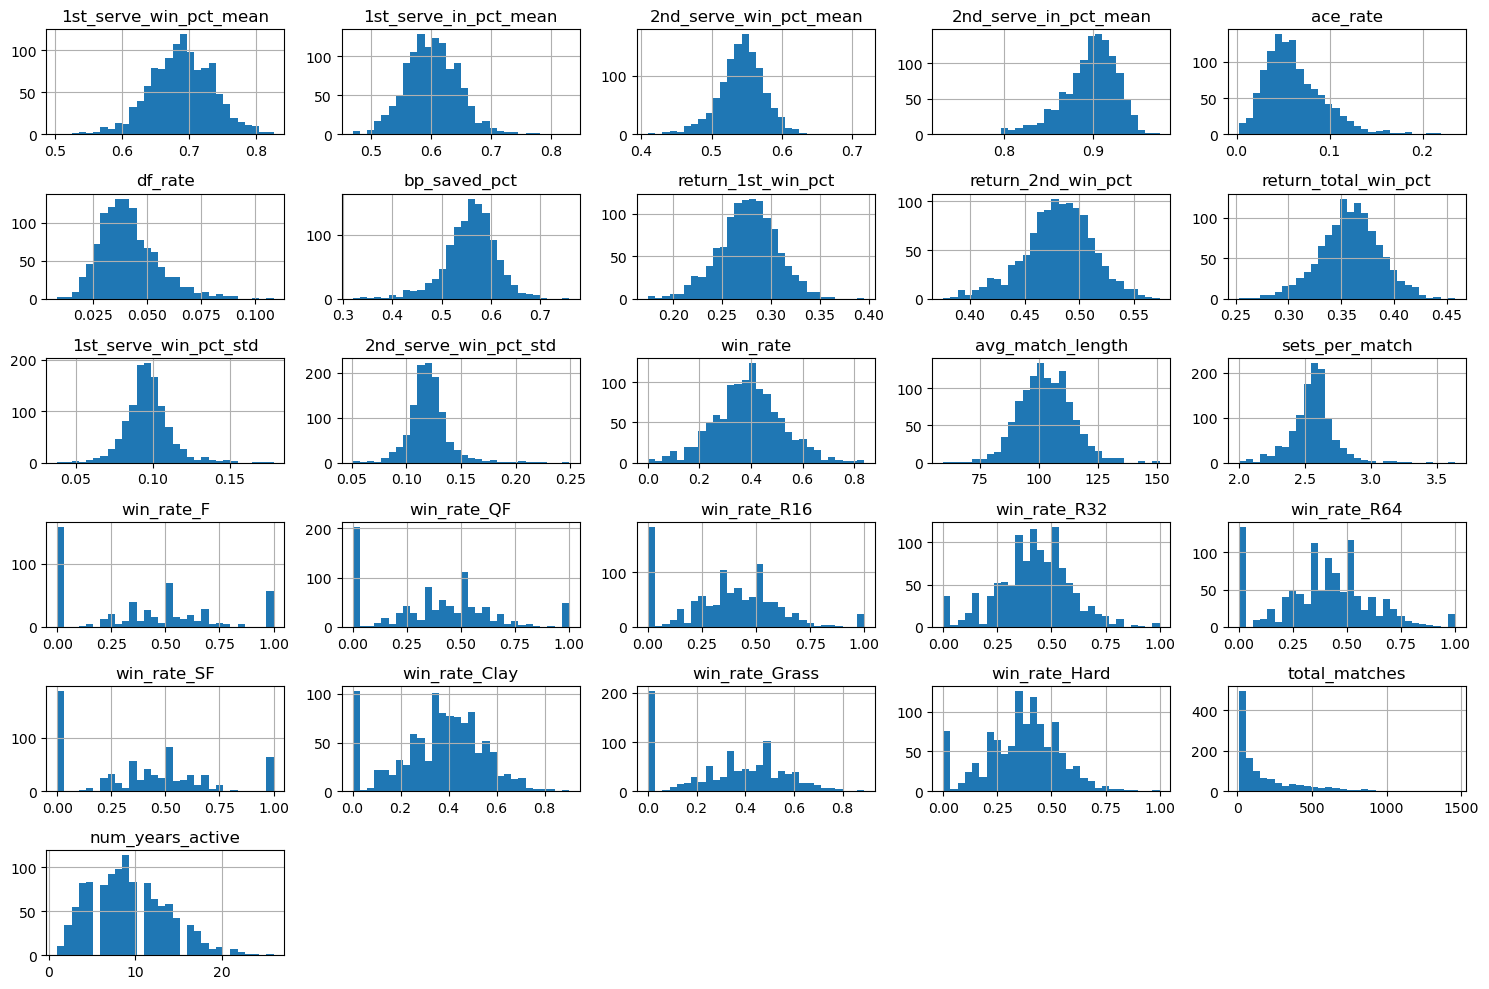

In [ ]:

####### Feature vector visualization
import matplotlib.pyplot as plt

# Visualize distribution of features (based on all data)
df = pd.read_csv('player_features.csv')
df.drop(columns=['player_id', 'first_year', 'last_year'], inplace=True)
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.title('Feature Distribution')
plt.savefig('../output/exploratory/player_feature_distribution.png', dpi=300)
plt.show()
